# Filtr Kalmana

Na podstawie <https://www.kalmanfilter.net/>

## Wprowadzenie i podstawowe pojęcia

**Średnia** (*mean*) - średnia wartość obliczona na podstawie znanego stanu **całej** populacji

$$ V_{mean} = \frac{1}{N}\sum^{N}_{n=1}V_n $$

In [21]:
import numpy as np

coin_values = np.array([5, 5, 10, 10, 10])
mean = np.mean(coin_values)

print(f"Wartości: {coin_values}")
print(f"Średnia: {mean}")

Wartości: [ 5  5 10 10 10]
Średnia: 8.0


**Wartość oczekiwana** (*expected value*) - wartość określająca spodziewany wynik ukrytej zmiennej

$$ W = \frac{1}{N}\sum^{N}_{n=1}W_n $$

In [22]:
generator = np.random.default_rng()

random_values = np.array(generator.normal(loc=80.0, scale=0.5, size=5))
expected_value = np.mean(random_values)

print(f"Losowe wartości: {random_values}")
print(f"Wartość oczekiwana: {expected_value}")

Losowe wartości: [79.39759713 80.1674425  80.88820777 79.01122841 80.80114753]
Wartość oczekiwana: 80.05312466713512


**Wariancja** (*variance*) - miara rozrzutu wartości zbioru od jego średniej

$$ \sigma^2 = \frac{1}{N} \sum^{N}_{n=1}(x_n - \mu)^2 $$

In [23]:
# zakładamy że jest to cała populacja
values = np.array(generator.normal(loc=1.9, scale=0.2, size=5))
mean = np.mean(values)
variance = np.var(values)

print(f"Wartości: {values}")
print(f"Średnia: {mean}")
print(f"Wariancja: {variance}")

Wartości: [1.9741018  1.77908587 1.97780302 1.84067319 2.17065278]
Średnia: 1.9484633300554244
Wariancja: 0.01823874745723448


**Odchylenie standardowe** (*standard deviation*) - pierwiastek kwadratowy wariancji 

$$ \sigma = \sqrt{\sigma^2} = \sqrt{\frac{1}{N} \sum^{N}_{n=1}(x_n - \mu)^2} $$

In [24]:
std_deviation = np.std(values)
print(f"Odchylenie standardowe: {std_deviation}")

Odchylenie standardowe: 0.13505090691007773


Podczas **estymacji** wariancji i odchylenia standardowego z **części populacji** należy zastosować dzielnik $\frac{1}{N-1}$ zamiast $\frac{1}{N}$ (Poprawka Bessela)

$$ \sigma = \sqrt{\sigma^2} = \sqrt{\frac{1}{N - 1} \sum^{N}_{n=1}(x_n - \mu)^2} $$

### Rozkład normalny (*normal distribution*)

Rozkład normalny (rozkład Gaussa) to krzywa dzwonowa opisana następującym wzorem:

$$ f(x;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi \sigma^2}}e^{\frac{-(x-\mu)^2}{2\sigma^2}} $$


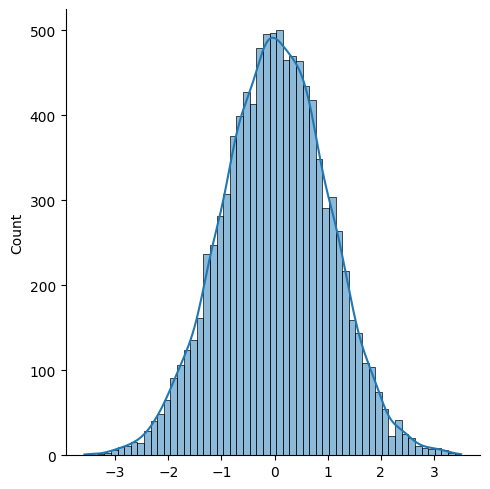

In [32]:
import seaborn as sns

values = generator.normal(loc=0.0, scale=1.0, size=10000)
sns.displot(values, kde=True)


## Filtr alfa-beta-gamma

## Jednowymiarowy filtr Kalmana

